# Anomaly Detection using Random Cut Forest

## Exploratory Data Analysis

In [0]:
# import libraries 
import pandas as pd 
import numpy as np
from datetime import datetime

import boto3
import botocore

import sys

# import sagemaker
#from sagemaker import RandomCutForest
# Add the directory containing features_eng to the Python path
lib_path = "/Workspace/Users/noor.alsabahi@bscanalytics.com/anomaly-detection/"
sys.path.append(lib_path)

import features_eng
import vis_lib

### Constants

In [0]:
DATA_FORMAT = "%m/%d/%Y %H:%M:%S"
FIG_SIZE = (40, 10)

Load data

In [0]:
# load data 
data_path = "/Workspace/Users/noor.alsabahi@bscanalytics.com/anomaly-detection/dataset/data-v2.csv" # gameday
df = pd.read_csv(data_path)

# Exploratory data analysis

In [0]:
df.head(3)

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.726318e+09,WARN,71.50.116.156,13a0e-a0f1-41d7-a70f-409b18e78813,DELETE,posts/explore/search,503,8.111,Condition story billion.
1,LOG-000001,1.726318e+09,INFO,11.88.16.107,65a0e-a0f1-41d7-a70f-409b18e78865,POST,posts/explore/search,502,6.055,Still career four want.
2,LOG-000002,1.726318e+09,ERROR,169.129.239.47,33a0e-a0f1-41d7-a70f-409b18e78833,DELETE,users/profile,502,8.895,Often floor fight than east team.


### Data Information (Nullable and non nullable value)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   log_identifier  50000 non-null  object 
 1   timestamp       50000 non-null  float64
 2   log_level       50000 non-null  object 
 3   ip_address      50000 non-null  object 
 4   user_id         50000 non-null  object 
 5   method          50000 non-null  object 
 6   path            50000 non-null  object 
 7   status_code     50000 non-null  int64  
 8   response_time   50000 non-null  float64
 9   message         50000 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.8+ MB


In [0]:
df[:1]

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.726318e+09,WARN,71.50.116.156,13a0e-a0f1-41d7-a70f-409b18e78813,DELETE,posts/explore/search,503,8.111,Condition story billion.


In [0]:
# data statistics 
df.describe()

,timestamp,status_code,response_time
count,5.000000e+04,50000.000000,50000.000000
mean,1.727068e+09,389.942920,3.534187
std,4.330170e+05,110.963187,2.714106
min,1.726318e+09,200.000000,0.100000
25%,1.726693e+09,400.000000,1.606000
50%,1.727068e+09,403.000000,2.980500
75%,1.727443e+09,500.000000,4.654000
max,1.727818e+09,503.000000,49.215000


Categorical data unique values

In [0]:
object_cols = df.select_dtypes(include=["object", "category"]).columns
object_cols

Index(['log_identifier', 'log_level', 'ip_address', 'user_id', 'method',
       'path', 'message'],
      dtype='object')

### Find Categorical Columns

In [0]:
unique_categorical_counts = df.select_dtypes(include=['object', 'category']).apply(lambda x:x.nunique())
unique_categorical_counts

log_identifier    50000
log_level             4
ip_address        49999
user_id             100
method                4
path                  8
message           50000
dtype: int64

In [0]:
categorical_cols = ['log_level', 'method']

In [0]:
for col in categorical_cols: 
    print(f" ---------------- {col} ---------------- ")
    print(df[col].value_counts())

 ---------------- log_level ---------------- 
ERROR    12724
WARN     12448
DEBUG    12435
INFO     12393
Name: log_level, dtype: int64
 ---------------- method ---------------- 
POST      12668
PUT       12476
GET       12470
DELETE    12386
Name: method, dtype: int64


### Find the size of the time window based on which the data is collected

In [0]:
# Example timestamp as a string
timestamp_start = df["timestamp"].min()
timestamp_end = df["timestamp"].max()

print(f"start = {timestamp_start}, end = {timestamp_end}")

start = 1726318206.527794, end = 1727818176.527794


In [0]:
# Example timestamp as a string
timestamp_start = df["timestamp"].min()
timestamp_end = df["timestamp"].max()

def timestamp2date(timestamp_str):

    # Convert the string to a float
    timestamp_float = float(timestamp_str)

    # Convert the timestamp to a datetime object
    dt = datetime.fromtimestamp(timestamp_str)

    # Format the datetime object to the desired output format
    formatted_dt = dt.strftime(DATA_FORMAT)
    return formatted_dt

formatted_dts = timestamp2date(timestamp_start)
formatted_dte = timestamp2date(timestamp_end)

print(f"Start date = {formatted_dts} \nEnd date   = {formatted_dte}")


Start date = 09/14/2024 12:50:06 
End date   = 10/01/2024 21:29:36


### Statistics about categorical data

In [0]:
df.log_level.value_counts()

ERROR    12724
WARN     12448
DEBUG    12435
INFO     12393
Name: log_level, dtype: int64

In [0]:
df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message'],
      dtype='object')

In [0]:
df.shape

(50000, 10)

## Data Visualizations

In [0]:
# Correlation
df.corr()

/root/.ipykernel/1246/command-2766795694305112-338281896:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,timestamp,status_code,response_time
timestamp,1.000000,0.000471,-0.002468
status_code,0.000471,1.000000,0.623177
response_time,-0.002468,0.623177,1.000000


 mean 11.575742843589527
 mean 11.836900384793545
 mean 11.633302154441132
 mean 11.660236472230128


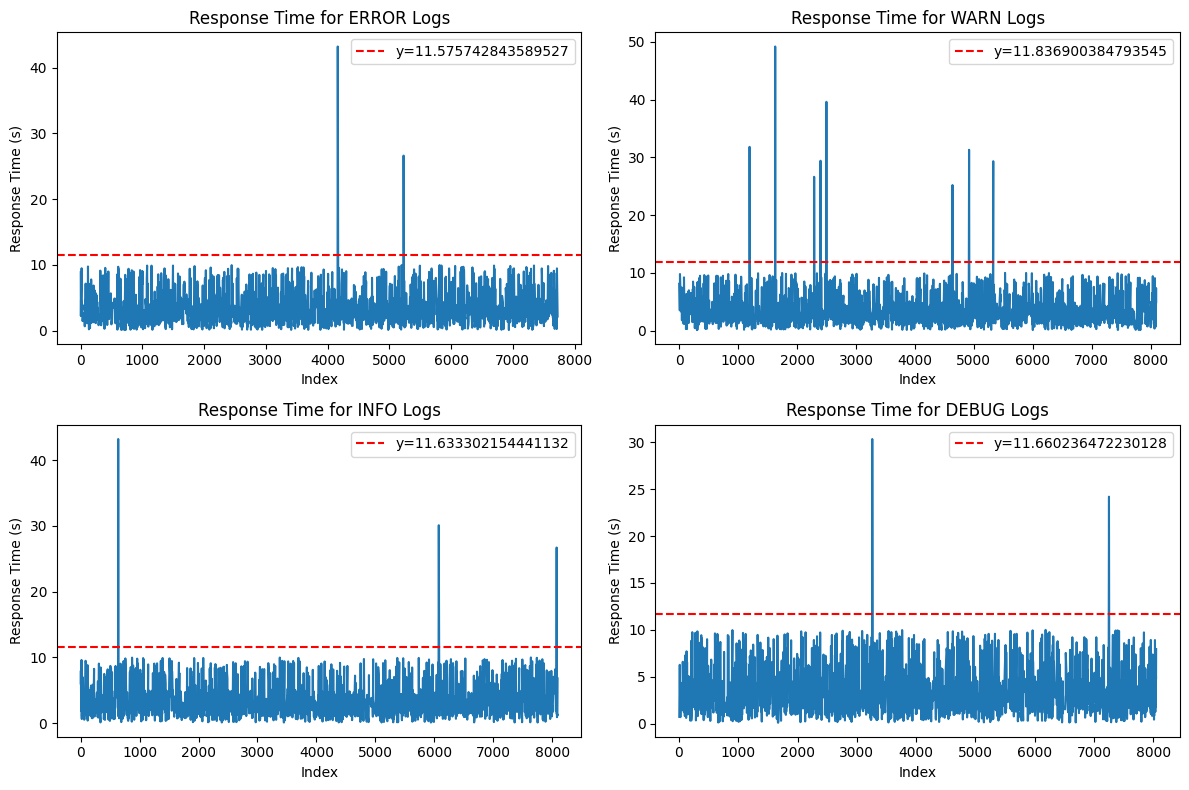

In [0]:
%matplotlib inline 

import matplotlib 
import matplotlib.pyplot as plt 

MaxNoRecords = 2000
# Define figure size and number of subplots (2x2)
FIG_SIZE = (12, 8)
fig, axes = plt.subplots(2, 2, figsize=FIG_SIZE)

# Define the log levels to visualize
log_levels = ["ERROR", "WARN", "INFO", "DEBUG"]

# Define the y-value where the horizontal line should be drawn
#y_value = 1.5

# Iterate over the log levels and create a plot for each one
for i, log_level in enumerate(log_levels):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    condition = (df.log_level == log_level)
    sigma = df[condition]["response_time"].std()
    response_time_mean = df[condition]["response_time"].mean()
    sigma3 = response_time_mean + 3 * sigma 
    print(f" mean {sigma3}")
    
    
    subset = df[condition]["response_time"][:MaxNoRecords]  # Select first 200 records with the log_level
    
    axes[row, col].plot(subset)
    axes[row, col].set_title(f"Response Time for {log_level} Logs")
    axes[row, col].set_xlabel("Index")
    axes[row, col].set_ylabel("Response Time (s)")
    
    y_value = sigma3
    # Draw a horizontal line at the specific y-value
    axes[row, col].axhline(y=y_value, color='r', linestyle='--', label=f'y={y_value}')
    axes[row, col].legend()

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()


In [0]:
df.head(2)

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.726265e+09,WARN,49.11.198.150,11a0e-a0f1-41d7-a70f-409b18e78811,DELETE,comments/add,403,4.146,Sample log message.
1,LOG-000001,1.726265e+09,WARN,102.47.55.135,56a0e-a0f1-41d7-a70f-409b18e78856,POST,articles/view,502,9.384,Sample log message.


In [0]:
df.status_code.value_counts()

503    5665
201    5642
200    5611
403    5561
401    5558
500    5554
502    5482
400    5476
404    5451
Name: status_code, dtype: int64

# Data Cleaning

### Remove Missing and Duplicate Records

1. Data Cleaning
Remove duplicates: Check for any duplicated log entries and remove them.
Handle missing values: drop rows for missing values to avoid bias in anomaly detection (instead of imputing the values)

In [0]:
df.shape[0]

50000

In [0]:
# drop rows of missing values
# df.dropna(subset=['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
#        'method', 'path', 'status_code', 'response_time'], inplace=True)
# df.drop_duplicates(inplace=True)



rncols = ['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id', 'method', 'path', 'status_code', 'response_time']
features_eng.df_cleaning(df, columns=rncols, inplace=True)

In [0]:
df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message'],
      dtype='object')

# Feature Selection and Engineering

We need to capture the relevant features and the interactions between response time, log_level, method, and path. 

RCF operates on numerical data, so we need to transform categorical features such as log_level, method, and path into numerical values. Here’s what to consider:
- *Response Time (response_time):* <br> 
This is the main feature for anomaly detection. The higher the response time, the more likely it is to be anomalous. But we’ll also consider the context of other features.
- *Log Level (log_level):*  <br>
Different log levels (e.g., ERROR, WARN, INFO) could indicate the severity of issues in the logs, which may affect response time. Use ordinal encoding for this feature:
INFO: 0, DEBUG: 1, WARN: 2, ERROR: 3 (reflecting increasing severity).
- *Method (method):*  <br>
 HTTP methods (GET, POST, etc.) might influence response times differently. Use one-hot encoding or ordinal encoding if the order is important. For simplicity, we will use one-hot encoding:
E.g., GET = [1, 0, 0, 0], POST = [0, 1, 0, 0], etc.
- *Path (path):*  <br>
 Some paths may take longer to respond due to complexity, load, or other factors. Group and aggregate the paths, especially if there are many unique values. You can:
Use frequency encoding or count-based encoding to assign numeric values based on how frequently a path appears.<br>

For example, if the path /posts/explore/search appears frequently, it might have a higher weight.- 

### Time-Based Features 

Time-Based Data: Since log data has timestamps, we should also consider time-based features:<br>
- *Time of day or hour of the day:* <br>  Different times of day can affect response time. Extract this from the timestamp.<br>
Feature: Hour of the day (0–23).<br><br>
- *Day of the week:* <br>
Response times could vary based on the day (e.g., weekdays vs weekends).<br>
Feature: Day of the week (0–6).

### Data Standardization

RCF works better when features are on the same scale. <br>
When detecting outliers, it's recommended to use standardization techniques like Z-score scaling instead of Min-Max scaling. <br>Min-Max scaling normalizes values to a range between 0 and 1, which can compress normal values into a narrower range. This squashing effect makes it difficult for the model to effectively identify anomalies, as the extreme values may take the upper limit, obscuring the distinction between normal and anomalous data points.<br>
<br>
Centering the Data: <br> Z-score scaling centers the data around zero by subtracting the mean. This means that the distribution of values will have a mean of 0, allowing for easier comparison of deviations from the mean.
<br><br>
Z= (X−μ)/σ<br>
μ = mean<br>
σ = Standard diviation
​	
 

In [0]:
df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message'],
      dtype='object')

In [0]:
# create day of the week, and hour of the day features

# # Convert timestamp to datetime
# df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# # Create new features
# df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
# df['hour'] = df['timestamp'].dt.hour  # Extract hour
df.head(3)

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.726318e+09,WARN,71.50.116.156,13a0e-a0f1-41d7-a70f-409b18e78813,DELETE,posts/explore/search,503,8.111,Condition story billion.
1,LOG-000001,1.726318e+09,INFO,11.88.16.107,65a0e-a0f1-41d7-a70f-409b18e78865,POST,posts/explore/search,502,6.055,Still career four want.
2,LOG-000002,1.726318e+09,ERROR,169.129.239.47,33a0e-a0f1-41d7-a70f-409b18e78833,DELETE,users/profile,502,8.895,Often floor fight than east team.


In [0]:
df['method'].value_counts()

POST      12668
PUT       12476
GET       12470
DELETE    12386
Name: method, dtype: int64

## Data Preparation

In [0]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

# DataFrame Selector for selecting specific columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names): 
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]


# Custom transformer to drop rows with missing values
class DropMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dropna()

# Custom transformer to round numerical values
class RoundValues(BaseEstimator, TransformerMixin):
    def __init__(self, decimals=2):  # Set default precision to 2
        self.decimals = decimals
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.round(X, self.decimals)  # Round the values to the specified decimal places

# feature engineering function and creating prepared numpy input
def create_prepared_numpy_array(df):

    # features_df = df[['timestamp', 'log_level', 'method', 'status_code', 'response_time']].copy()

    prepared_data_cols = ['log_level', 'PUT', 'GET', 'POST', 'DELETE', 'response_time',] # day_of_week', 'hour'

    prepared_data_cols = ['response_time',]
    # Categorical pipeline for log_level and method
    cat_attributes_log_level = ['log_level']
    cat_attributes_method = ['method']
    # Numerical pipeline for response_time, path_encoded, hour, day_of_week
    # num_attributes_day_time = ['day_of_week', 'hour'] 
    response_time_attributes = ['response_time', ] 


    log_level_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attributes_log_level)),
        ('drop_missing', DropMissingValues()),  # Drop rows with missing values
        ('ordinal_encoder', OrdinalEncoder(categories=[['DEBUG', 'INFO', 'WARN', 'ERROR']])),  # Ordinal encoding
        ('scaler', MinMaxScaler(feature_range=(0.2, 1))),  # Normalize the numerical features
        ('rounder', RoundValues(decimals=2)), 
    ])

    # day_time_pipeline = Pipeline([
    #     ('selector', DataFrameSelector(num_attributes_day_time)),
    #     ('drop_missing', DropMissingValues()),  # Drop rows with missing values
    #     ('scaler', StandardScaler()),  # Normalize the numerical features
    #     ('rounder', RoundValues(decimals=2)), 
    # ])

    response_time_pipeline = Pipeline([
        ('selector', DataFrameSelector(response_time_attributes)),
        ('drop_missing', DropMissingValues()),  # Drop rows with missing values
        ('scaler', StandardScaler()),  # Normalize the numerical features
    ])

    method_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attributes_method)),
        ('drop_missing', DropMissingValues()),  # Drop rows with missing values
        ('onehot_encoder', OneHotEncoder(sparse=False))#, drop='first'))  #sparse_output with sagemaker, and sparse with databricks One-hot encoding
    ])

    # Full pipeline to combine all pipelines
    full_pipeline = Pipeline(steps=[
        ## ('feature_creator', FeatureCreator(timestamp_col='timestamp')),  # Create new features
        ('union', FeatureUnion(transformer_list=[
        # ("log_level_pipeline", log_level_pipeline),# log_level
        # ("method_pipeline", method_pipeline), # 'PUT', 'GET', 'POST', 'DELETE'
        ## ("day_time_pipeline", day_time_pipeline),#'day_of_week', 'hour' 
        ("response_time_pipeline", response_time_pipeline),# 'response_time'  
        ]))
    ])

    # Prepare the data using the full pipeline
    prepared_data = full_pipeline.fit_transform(df)

    # Convert to DataFrame for further processing if needed
    prepared_df = pd.DataFrame(prepared_data, columns=prepared_data_cols)

    # Return prepared data 
    return prepared_data, prepared_df

# Data cleaning 
def df_cleaning(df, columns, inplace=False):
    """
    Clean the DataFrame by dropping rows with missing values in specified columns 
    and removing duplicate rows.

    :param df: DataFrame to clean.
    :param columns: List of column names to check for missing values.
    :param inplace: Boolean value indicating whether to modify the DataFrame in place.
                    If True, the operations will be performed on the original DataFrame. 
                    If False, a new DataFrame will be returned.
    :return: Cleaned DataFrame with rows containing NaN in the specified columns dropped,
             and duplicate rows removed. If inplace=True, returns None.
    
    Steps:
    1. Drop rows with missing values (NaN) in the specified columns.
    2. Drop duplicate rows from the DataFrame.
    """

    if inplace: 
        df.dropna(subset=columns, inplace=inplace)
        df.drop_duplicates(inplace=inplace)
        return None
    else: 
        cleaned_df = df.dropna(subset=columns)
        new_df = cleaned_df.drop_duplicates()
        return new_df

# Calculate threshold 
def calc_threshold(scores):
    from statistics import mean, stdev

    score_mean = mean(scores)
    score_std = stdev(scores)
    score_max = max(scores)
    threshold = score_mean + 3 * score_std
    return threshold, score_mean, score_std

def append_score_and_outlier_to_df(df, scores):
    threshold, score_mean, score_std = calc_threshold(scores)

    df["score"] = pd.Series(scores, index=df.index)
    # Create a new "outlier" column in the DataFrame
    df["outlier"] = df["score"].apply(lambda x: 1 if x > threshold else 0)

    # anomalies = df[df["score"] > threshold]
    return df #, anomalies


In [0]:
#prepared_data, prepared_df = features_eng.create_prepared_numpy_array(df)
prepared_data, prepared_df = create_prepared_numpy_array(df)

# # Display prepared data shape
# print(prepared_data.shape)
# prepared_data


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

In [0]:
prepared_df.head()

,response_time
0,1.686322
1,0.928791
2,1.975187
3,1.641003
4,-0.480527


# Training!!

### Split data between training and testing

In [0]:
# Split
split_index = int(len(prepared_data) * 0.8)  # 80% for training

X_train = prepared_data[:split_index]  # First 80% of the data
X_test = prepared_data[split_index:]     # Last 20% of the data


In [0]:
X_train.shape , X_test.shape

((40000, 1), (10000, 1))

In [0]:
type(X_train)

numpy.ndarray

In [0]:
# Install scikit-learn if it's not installed
# %pip install scikit-learn

# Import necessary libraries
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

## Training One Class SVM for Anomaly Detection

In [0]:
"""
kernel: Defines the kernel type to be used in the algorithm. Common options:
'rbf' (Radial Basis Function) [most commonly used for anomaly detection]
'linear'
'poly' (polynomial)
'sigmoid'
"""

# Initialize One-Class SVM model with default hyperparameters
# svm_model = OneClassSVM(
#     kernel='rbf',         # Kernel function, commonly 'rbf' (Radial Basis Function) for anomaly detection
#     gamma='scale',        # Kernel coefficient; auto or scale can be used based on data scaling
#     nu=0.01,               # An upper bound on the fraction of training errors and a lower bound on the support vectors (0 < nu <= 1)| Lower values (e.g., 0.1) make the model more sensitive to anomalies, while higher values (e.g., 0.9) make it stricter. 
#     tol=1e-3,             # Tolerance for stopping criterion | You can reduce it to get a more precise model at the cost of computation time.
#     shrinking=True,       # Whether to use the shrinking heuristic | This can improve the speed of convergence, but in some cases, disabling it (False) can help with larger datasets.
#     cache_size=200        # Size of the kernel cache in MB
# )

svm_model = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)

# Train the model
svm_model.fit(X_train)



Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

OneClassSVM(gamma=0.01, nu=0.01)

## Inference 

In [0]:

# Make predictions (1: normal, -1: anomaly)
y_pred_test = svm_model.predict(X_test)

# Output the training predictions
print("Training predictions:", y_pred_test)

Training predictions: [1 1 1 ... 1 1 1]


In [0]:
anomalies_count = np.sum(y_pred_test == -1)
print(f"Number of anomalies: {anomalies_count}")

Number of anomalies: 96


In [0]:
#len(y_pred_test), type(y_pred_test), 

(10000, numpy.ndarray)

In [0]:
Noooor we stopped here!

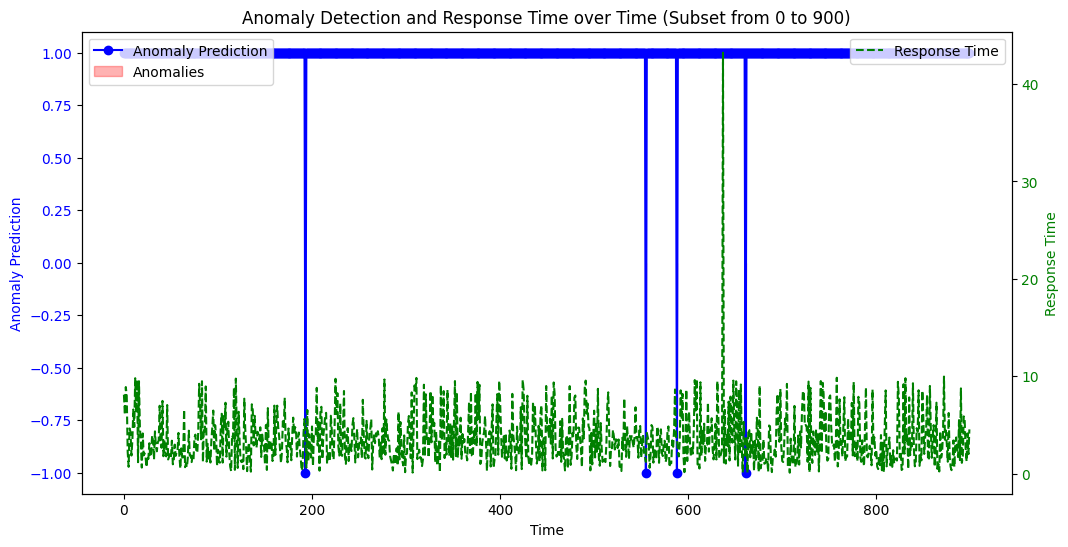

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Select a subset of the predictions (e.g., first 100 points)
subset_start = 0  # Adjust the start of the subset
subset_end = 900  # Adjust the end of the subset
y_pred_test_subset = y_pred_test[subset_start:subset_end]

# Create a corresponding time axis for the subset
time_axis_subset = np.arange(subset_start, subset_end)

# Assuming df['response_time'] is available and has the same length as y_pred_test
response_time_subset = df['response_time'].values[subset_start:subset_end]  # Adjust based on your actual DataFrame

# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot y_pred_test predictions on the first y-axis
ax1.plot(time_axis_subset, y_pred_test_subset, label="Anomaly Prediction", color='b', linestyle='-', marker='o')
ax1.fill_between(time_axis_subset, y_pred_test_subset, where=(y_pred_test_subset == -1), color='r', alpha=0.3, label="Anomalies")
ax1.set_xlabel('Time')
ax1.set_ylabel('Anomaly Prediction', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for response_time
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(time_axis_subset, response_time_subset, label="Response Time", color='g', linestyle='--')
ax2.set_ylabel('Response Time', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Adding title and legends
plt.title(f'Anomaly Detection and Response Time over Time (Subset from {subset_start} to {subset_end})')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()


SVM Did not do a good job in predecting anomalies when dealing with random dataset

## Training ARIMA 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming X_train is your scaled numpy array of response times
response_time = pd.Series(X_train.flatten())  # Convert to pandas Series for time series analysis
response_time_test = pd.Series(X_test.flatten())  # Convert to pandas Series for time series analysis
# Fit the ARIMA model
# You can adjust the order parameter (p, d, q) based on your data characteristics

p = 1 # number of lags
d = 0 # time series is stationary 
q = 2 # number of moving average terms
model = ARIMA(response_time, order=(p, d, q))  # Example order, adjust as needed
model_fit = model.fit()

"""
Based on the diagram you provided:
Count the number of lags in the ACF plot that are significantly above zero before they drop off to the confidence level. This gives you 
q.
Count the number of lags in the PACF plot that are significantly above zero before they drop off to the confidence level. This gives you 
p.
"""

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

'\nBased on the diagram you provided:\nCount the number of lags in the ACF plot that are significantly above zero before they drop off to the confidence level. This gives you \nq.\nCount the number of lags in the PACF plot that are significantly above zero before they drop off to the confidence level. This gives you \np.\n'

In [0]:
# Split index based on the length of prepared_data
split_index = int(len(prepared_data) * 0.8)  # 80% for training

# Split the original DataFrame based on the same index
train_df = df.iloc[:split_index]  # First 80% of the rows
test_df = df.iloc[split_index:]  # Remaining 20% of the rows
print(train_df.shape)
print(test_df.shape)

(40000, 12)
(10000, 12)


In [0]:
#type(  response_time_pred), response_time_pred.shape, test_df.shape

(pandas.core.series.Series, (40000,), (10000, 12))

In [0]:

# Generate predictions
response_time_pred = model_fit.predict(start=0, end=len(response_time_test)-1, dynamic=False)

# Calculate residuals
residuals = response_time_test - response_time_pred

# Define a threshold for anomalies (e.g., mean + 3*std of residuals)
threshold = response_time_pred.mean() + 3 * response_time_pred.std()
# anomalies = residuals[residuals > threshold]
test_df["score"] = response_time_pred.values #  pd.Series(response_time_pred, index=test_df.index)
test_df["outlier"] = test_df["score"].apply(lambda x: 1 if x > threshold else 0)
anomalies = test_df["outlier"]
print(f"threshold = {threshold}")


threshold = 0.025731235799459677


/root/.ipykernel/1246/command-2766795694305211-3689440791:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["score"] = response_time_pred.values #  pd.Series(response_time_pred, index=test_df.index)
/root/.ipykernel/1246/command-2766795694305211-3689440791:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["outlier"] = test_df["score"].apply(lambda x: 1 if x > threshold else 0)


In [0]:
test_df["score"]

40000   -0.000018
40001   -0.008238
40002    0.005893
40003   -0.008856
40004    0.003858
           ...   
49995    0.001941
49996    0.000164
49997    0.000179
49998   -0.001426
49999   -0.007936
Name: score, Length: 10000, dtype: float64

In [0]:
test_df["outlier"].sum()

19

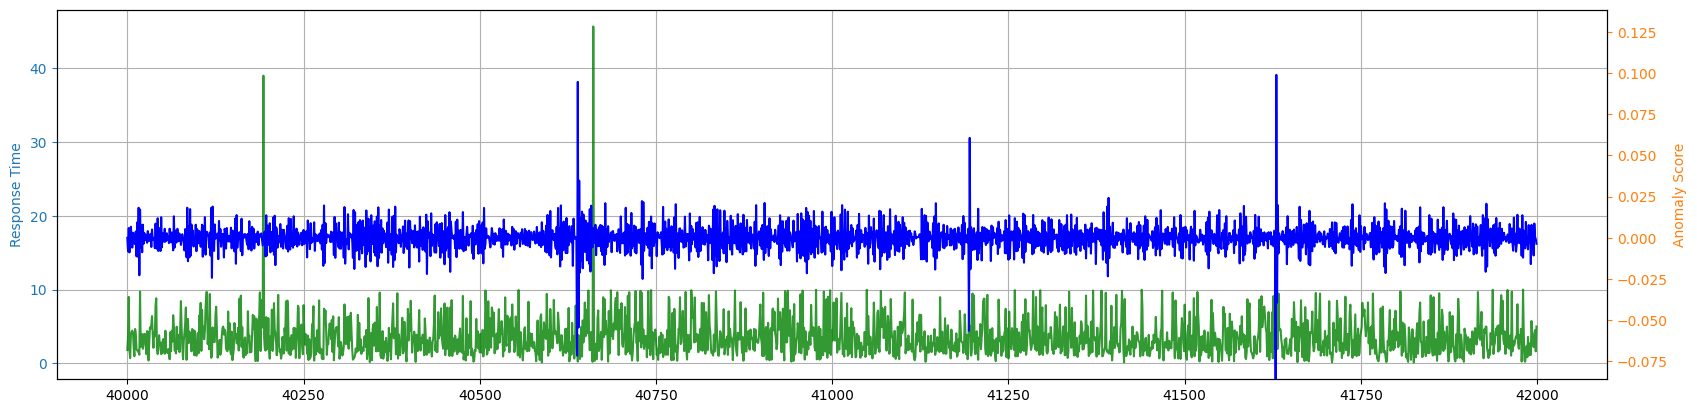

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

maxNoRecords = 2000
scores = response_time_pred
#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(test_df)
# start, end = 5500, 6500
data_subset = test_df[start:end][:maxNoRecords]

ax1.plot(data_subset["response_time"], color="green", alpha=0.8)
ax2.plot(data_subset["score"], color="blue")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Response Time", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

#ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(20)

### Conclusion
ARIMA did not do well, because the data is not realistic, it is random. While in general, ARIMA over performs RCF when dealing with realistic data with seasonality and trend.
So far, the RCF did a great job when it comes to anomaly detection, regardless if the data is random or not

In [0]:
response_time

array([8.111, 6.055, 8.895, ..., 1.618, 9.356, 1.809])

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:730)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:448)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:448)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

## Calculating ARIMA Parameters

### Notes: 
Explanation of the Code:

ADF Test: This function checks if the time series is stationary. If the p-value is above 0.05, the series is non-stationary, and differencing is applied.<br/>
Differencing: The series is differenced until it becomes stationary, and the order of differencing
d
d is recorded.<br/>
ACF and PACF: These plots help identify the values for 
p
p and 
q
q. <br/>
Typically, we look for the lag at which the ACF and PACF plots drop to zero or become negligible.
Notes on Using ACF and PACF:
ACF Plot: The number of lags that significantly exceed the confidence interval indicates the potential value of 
q
q.<br/>
PACF Plot: The lag at which the PACF drops below the significance line can help determine 
p
p.<br/>
By analyzing these plots, we can choose the values of 
p
p and 
q
q that are appropriate for your data. It's often helpful to test multiple configurations to find the best-fitting model based on criteria such as AIC or BIC.<br/>

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Order of Differencing (d): 0


/databricks/python/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


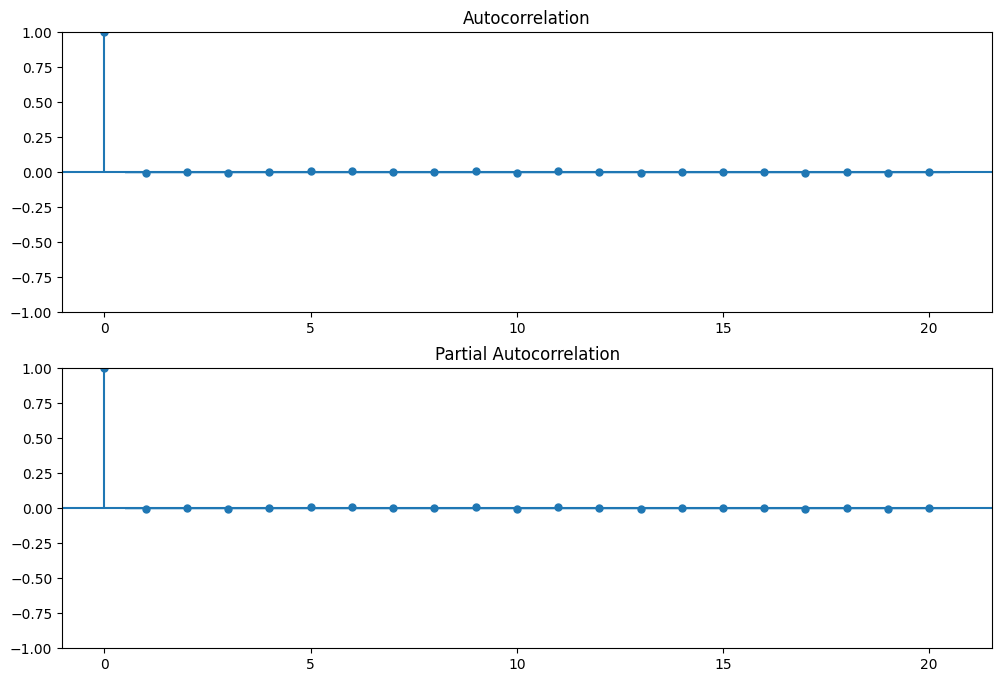

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df['response_time'] is your time series data
response_time = df['response_time'].values

# Step 1: ADF Test to determine 'd' (Order of Differencing)
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value

# Check the stationarity of the series
d = 0  # Initialize differencing order
p_value = adf_test(response_time)
while p_value >= 0.05:  # If p-value is greater than 0.05, the series is non-stationary
    response_time = np.diff(response_time)  # Difference the series
    d += 1
    p_value = adf_test(response_time)

print(f"Order of Differencing (d): {d}")

# Step 2: Plot ACF and PACF to determine 'p' and 'q'
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(response_time, ax=ax[0], lags=20)
plot_pacf(response_time, ax=ax[1], lags=20)
plt.show()

# You can use the plots to visually inspect where the ACF and PACF cut off


In [0]:
p_value

0.0

### Deploy Infernece Endpoint

In [0]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2024-10-14-10-44-54-350
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2024-10-14-10-44-54-350
INFO:sagemaker:Creating endpoint with name randomcutforest-2024-10-14-10-44-54-350


----------!

In [0]:
print(f"Endpoint name: {rcf_inference.endpoint}")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2024-10-14-10-44-54-350


In [0]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

results = rcf_inference.predict(X_test)

In [0]:
len(results['scores'])

10000

In [0]:
# Split index based on the length of prepared_data
split_index = int(len(prepared_data) * 0.8)  # 80% for training

# Split the original DataFrame based on the same index
train_df = df.iloc[:split_index]  # First 80% of the rows
test_df = df.iloc[split_index:]  # Remaining 20% of the rows
print(train_df.shape)
print(test_df.shape)

(40000, 10)
(10000, 10)


### Calculate the Threshold and Append Score to the DataFrame

In [0]:
# s into a python list 
scores = [datum["score"] for datum in results["scores"]]
threshold, score_mean, score_std = features_eng.calc_threshold(scores)
threshold

1.3721525975940931

In [0]:
test_df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message', 'score',
       'outlier'],
      dtype='object')

In [0]:
test_df = features_eng.append_score_and_outlier_to_df(test_df, scores)

test_df.head()

/tmp/ipykernel_10743/510106535.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["score"] = pd.Series(scores, index=df.index)
/tmp/ipykernel_10743/510106535.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outlier"] = df["score"].apply(lambda x: 1 if x > threshold else 0)


,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message,score,outlier
40000,LOG-040000,1.727465e+09,WARN,138.141.1.239,91a0e-a0f1-41d7-a70f-409b18e78891,GET,main/explore/category,502,1.661,Sample log message.,0.685728,0
40001,LOG-040001,1.727465e+09,DEBUG,88.45.187.210,24a0e-a0f1-41d7-a70f-409b18e78824,GET,posts/explore/search,201,0.927,Sample log message.,0.841680,0
40002,LOG-040002,1.727465e+09,ERROR,57.212.125.194,90a0e-a0f1-41d7-a70f-409b18e78890,POST,main/blog,401,2.027,Sample log message.,0.770533,0
40003,LOG-040003,1.727465e+09,ERROR,67.173.246.167,59a0e-a0f1-41d7-a70f-409b18e78859,DELETE,main/explore/category,200,0.399,Sample log message.,0.995674,0
40004,LOG-040004,1.727465e+09,WARN,214.42.65.29,55a0e-a0f1-41d7-a70f-409b18e78855,PUT,blog/app/blog,404,2.566,Sample log message.,0.752391,0


In [0]:
test_df['outlier'].sum()

12

### Visualize the test data

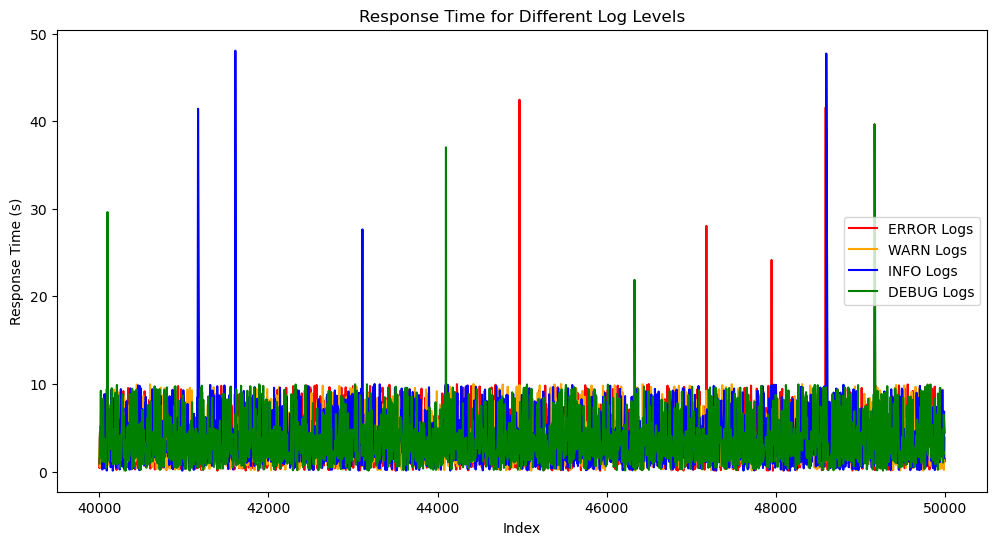

In [0]:
%matplotlib inline 

import matplotlib.pyplot as plt 

# Define figure size
FIG_SIZE = (12, 6)
plt.figure(figsize=FIG_SIZE)

# Define the log levels to visualize
log_levels = ["ERROR", "WARN", "INFO", "DEBUG"]

# Colors for each log level
colors = ['red', 'orange', 'blue', 'green']

# Plot each log level's response time with a different color
for i, log_level in enumerate(log_levels):
    condition = (test_df.log_level == log_level)
    subset = test_df[condition]["response_time"] # Select first 200 records with the log_level
    
    plt.plot(subset, label=f"{log_level} Logs", color=colors[i])

# Add title, labels, and legend
plt.title("Response Time for Different Log Levels")
plt.xlabel("Index")
plt.ylabel("Response Time (s)")
plt.legend()

# Show the plot
plt.show()


### Visualize the Score 

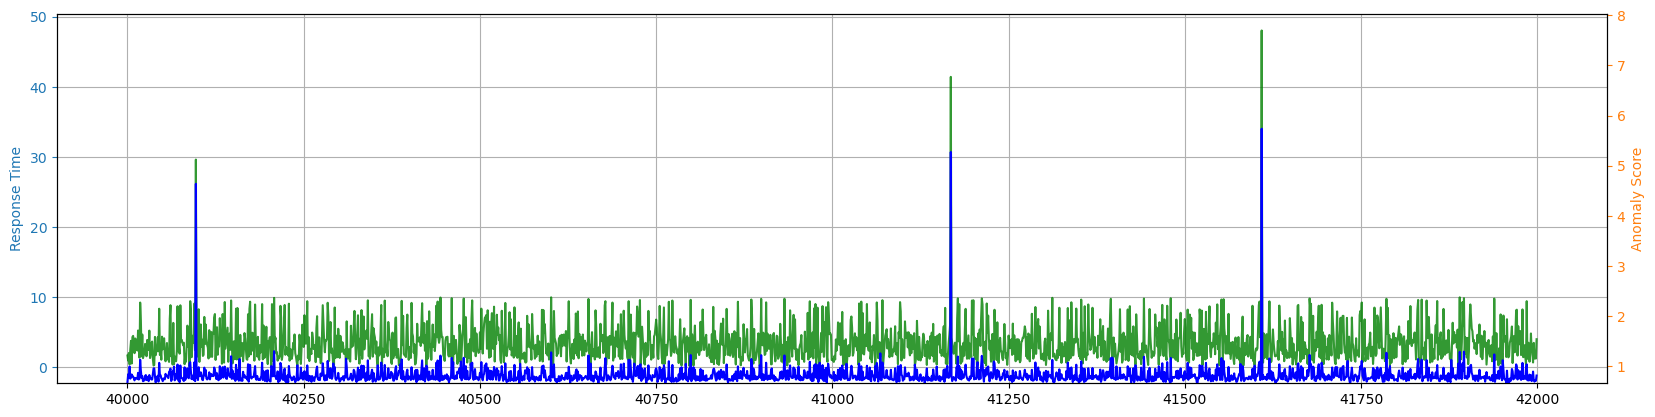

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

maxNoRecords = 2000
#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(test_df)
# start, end = 5500, 6500
data_subset = test_df[start:end][:maxNoRecords]

ax1.plot(data_subset["response_time"], color="green", alpha=0.8)
ax2.plot(data_subset["score"], color="blue")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Response Time", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

#ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(20)

In [0]:
test_df["outlier"].sum()

12

In [0]:
test_df.head()

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message,score,outlier
40000,LOG-040000,1.727465e+09,WARN,138.141.1.239,91a0e-a0f1-41d7-a70f-409b18e78891,GET,main/explore/category,502,1.661,Sample log message.,0.685728,0
40001,LOG-040001,1.727465e+09,DEBUG,88.45.187.210,24a0e-a0f1-41d7-a70f-409b18e78824,GET,posts/explore/search,201,0.927,Sample log message.,0.841680,0
40002,LOG-040002,1.727465e+09,ERROR,57.212.125.194,90a0e-a0f1-41d7-a70f-409b18e78890,POST,main/blog,401,2.027,Sample log message.,0.770533,0
40003,LOG-040003,1.727465e+09,ERROR,67.173.246.167,59a0e-a0f1-41d7-a70f-409b18e78859,DELETE,main/explore/category,200,0.399,Sample log message.,0.995674,0
40004,LOG-040004,1.727465e+09,WARN,214.42.65.29,55a0e-a0f1-41d7-a70f-409b18e78855,PUT,blog/app/blog,404,2.566,Sample log message.,0.752391,0


In [0]:
test_df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message', 'score',
       'outlier'],
      dtype='object')

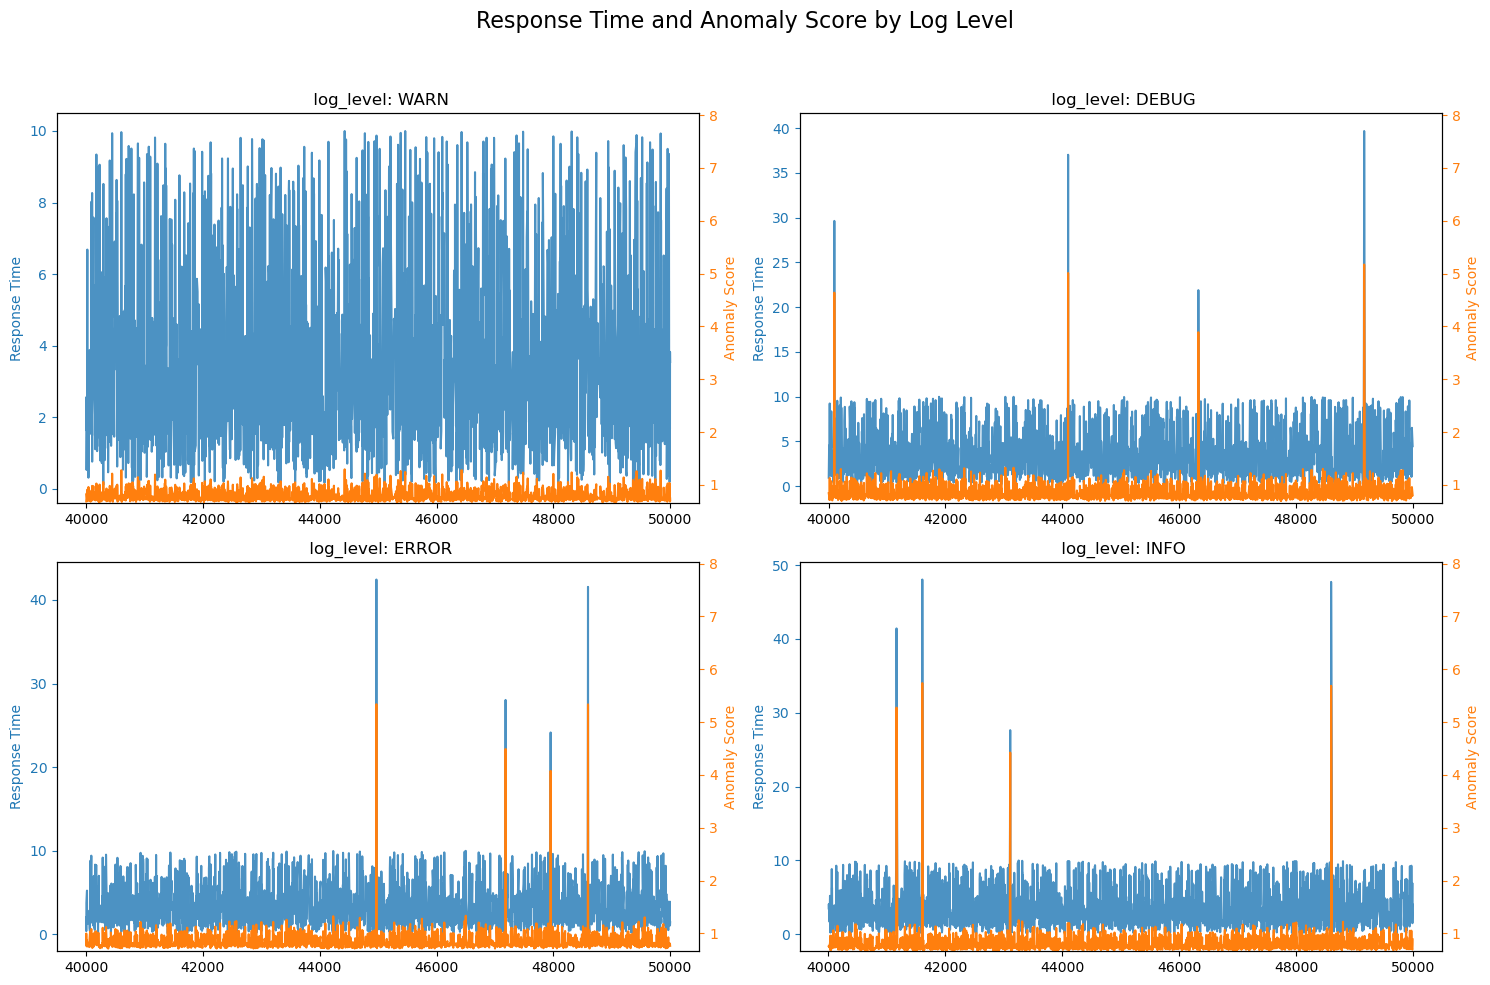

In [0]:
#from vis_functions import vis_response_time_score_foreach

vis_lib.vis_response_time_score_foreach(test_df, 'log_level')

In [0]:
test_df.columns

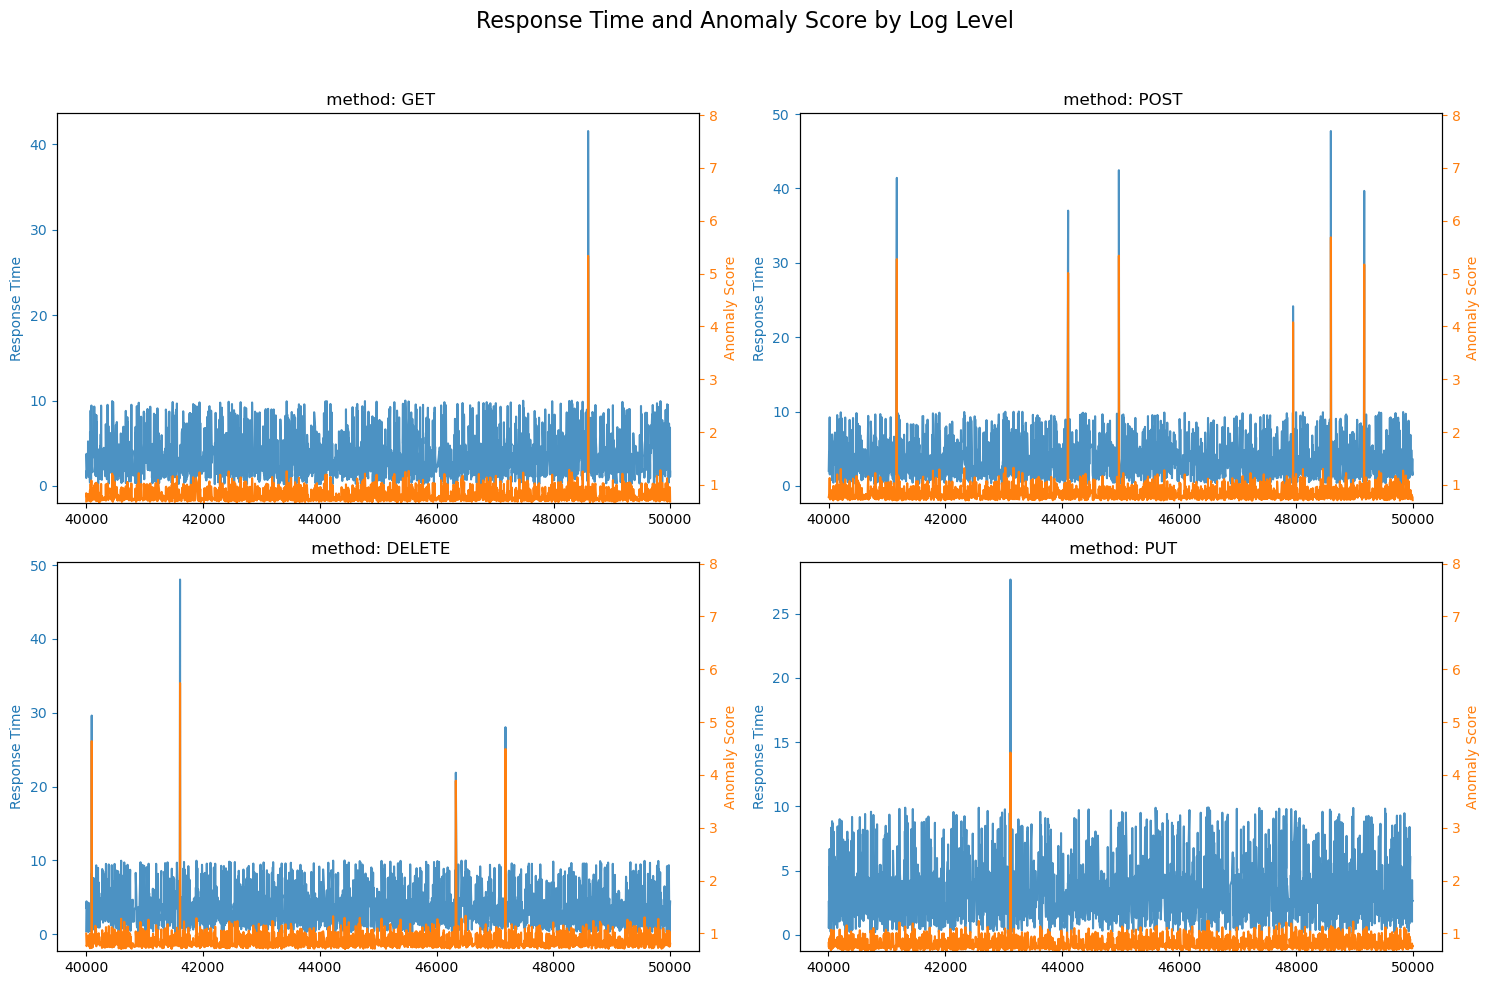

In [0]:
import vis_lib
vis_lib.vis_response_time_score_foreach(test_df, 'method')

In [0]:
test_df.head()

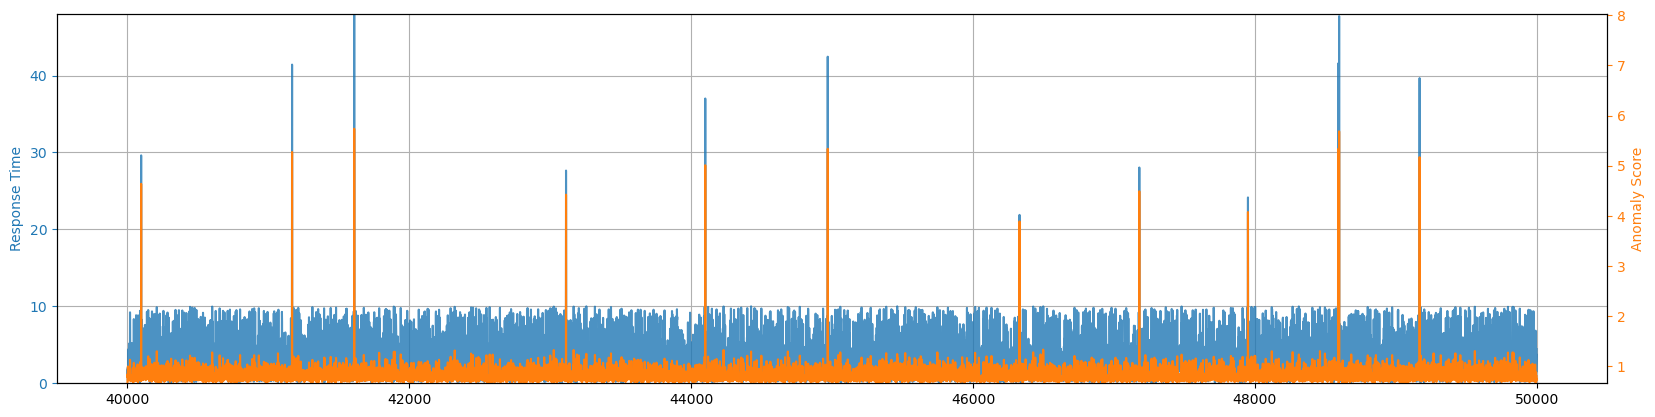

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(test_df)
dataset_subset = test_df[start:end]

ax1.plot(dataset_subset["response_time"], color="C0", alpha=0.8)
ax2.plot(dataset_subset["score"], color="C1")

#visualize one of the venues
#ax3.plot(dataset_subset[dataset.Venue == 'XOFF']["TradingTime"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Response Time", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

#ax3.tick_params("y", colors="C3")

ax1.set_ylim(0, max(dataset_subset["response_time"])) # max = 24 hours
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(20)


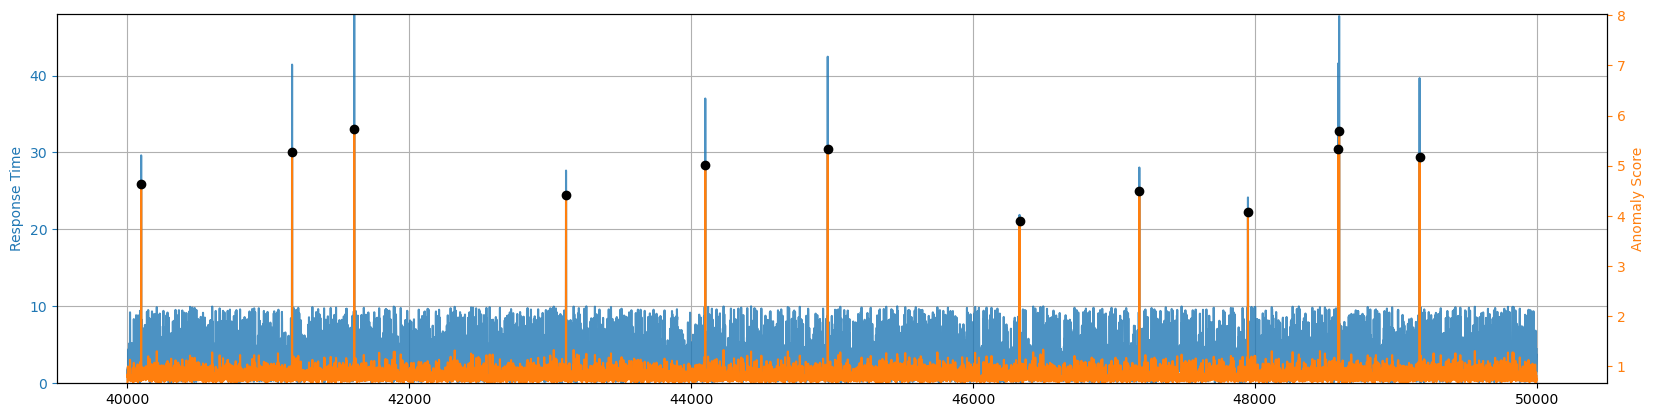

In [0]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

# Store data with Score in S3

In [0]:
import boto3
import sagemaker 
sess = sagemaker.Session()


#bucket = 'dataset-noora'
test_df.to_csv('data_with_scores_with_header.csv', index=False, header=True)
data_with_scores_path = sess.upload_data(
    path='data_with_scores_with_header.csv', 
    bucket=downloaded_data_bucket,#"bsc-gameday-2024"
    key_prefix=downloaded_data_prefix # "dataset" 
)
data_with_scores_path


's3://bsc-gameday-2024/dataset/data_with_scores_with_header.csv'